#### LICENSE

These notes are released under the “Creative Commons
Attribution-ShareAlike 4.0 International” license. See the
**human-readable version**
[here](https://creativecommons.org/licenses/by-sa/4.0/) and the **real
thing**
[here](https://creativecommons.org/licenses/by-sa/4.0/legalcode).

## Cross-validation when the model is chosen using the data

When the model or predictor
is chosen (or tuned) using the training data, one needs to be careful when 
using CV to assess its future prediction properties. 
Consider the
following synthetic data set

In [1]:
dat <- read.table('fallacy.dat', header=TRUE, sep=',')

These data were generated following a Gaussian model without any 
explanatory variable (Y ~ N(mu, 1)), and we know that the standard
deviation of the errors is 1. The explanatory variables in the 
data set are random noise, generated after the response was
recorded. 


Note that since we know what the
"true" model is, we can derive the "optimal" predictor for Y
in terms of mean squared prediction error. 
However, let us ignore this knowledge, and build a linear model
instead. 

Given how many variables are available, we are concerned with 
multicollinearity and overfitting, so we use 
forward stepwise to select a good subset of them to include in our linear
model:

In [2]:
library(MASS)
p <- ncol(dat)
null <- lm(Y~1, data=dat)
full <- lm(Y~., data=dat) # needed for stepwise
step.lm <- stepAIC(null, scope=list(lower=null, upper=full), direction='forward', trace=FALSE)

Note that stepwise variable selection retains a relatively large number of variables:

In [3]:
print(coef(step.lm))

(Intercept)         X27         X13         X93        X106         X69 
 0.13136223 -0.37820738  0.36837204 -0.25569774  0.28518809 -0.20580120 
       X104         X89         X12         X59          X1        X102 
 0.19148303 -0.21073345  0.18012975 -0.13806621 -0.12954054 -0.19709447 
        X24         X42        X110          X8         X40         X80 
-0.17467532 -0.11678525 -0.07595136  0.13592890  0.14419950 -0.17273999 
        X51         X19         X60         X85         X63         X38 
-0.12106730  0.10647029  0.09526038  0.09515682  0.09045875 -0.12111116 
       X108         X46         X47         X53         X41 
 0.10783822  0.09543940 -0.10665937  0.10062989  0.08471490 


We now use 50 runs of 5-fold CV to
compare the MSPE of the **null** model (which we know is "best") and 
that of the model we built with forward stepwise:

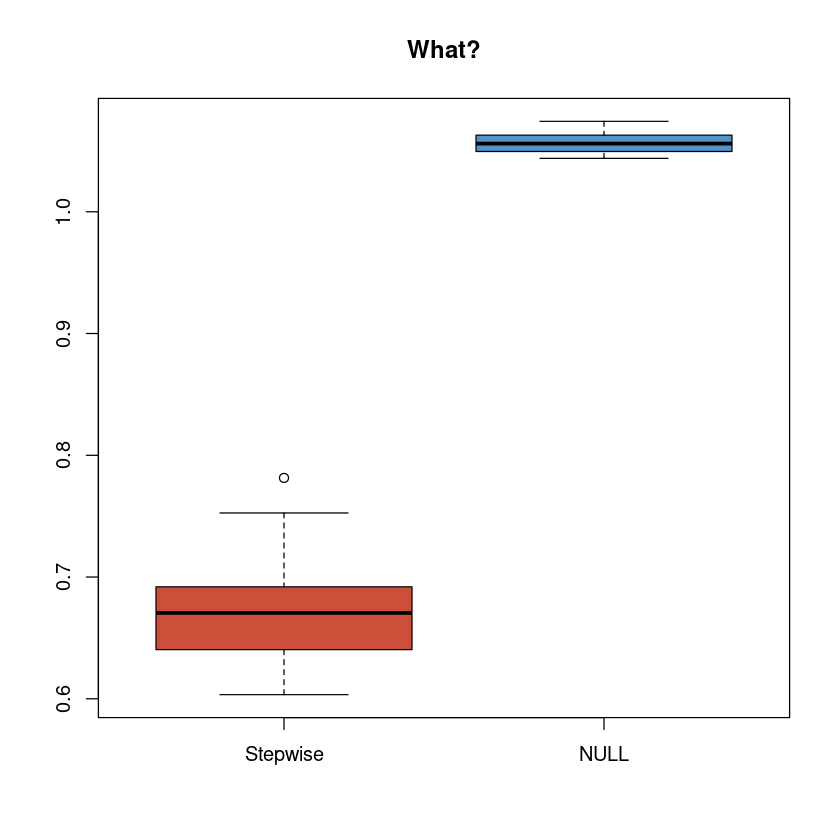

In [4]:
n <- nrow(dat)
ii <- (1:n) %% 5 + 1
set.seed(123)
N <- 50
mspe.n <- mspe.st <- rep(0, N)
for(i in 1:N) {
  ii <- sample(ii)
  pr.n <- pr.st <- rep(0, n)
  for(j in 1:5) {
    tmp.st <- update(step.lm, data=dat[ii != j, ])
    pr.st[ ii == j ] <- predict(tmp.st, newdata=dat[ii == j, ])
    pr.n[ ii == j ] <- with(dat[ii != j, ], mean(Y))
  }
  mspe.st[i] <- with(dat, mean( (Y - pr.st)^2 ))
  mspe.n[i] <- with(dat, mean( (Y - pr.n)^2 ))
}
boxplot(mspe.st, mspe.n, names=c('Stepwise', 'NULL'), col=c('tomato3', 'steelblue3'), main='What?')

In [5]:
summary(mspe.st)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6034  0.6411  0.6705  0.6703  0.6916  0.7814 

In [6]:
summary(mspe.n)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.044   1.050   1.056   1.057   1.063   1.074 

### Something is wrong\! 

What? Why?

In [7]:
n <- nrow(dat)
ii <- (1:n) %% 5 + 1
set.seed(123)
N <- 50
mspe.n <- mspe.st <- rep(0, N)
for(i in 1:N) {
  ii <- sample(ii)
  pr.n <- pr.st <- rep(0, n)
  for(j in 1:5) {
    null <- lm(Y~1, data=dat[ii != j, ])
    full <- lm(Y~., data=dat[ii != j, ]) # needed for stepwise
    step.lm <- stepAIC(null, scope=list(lower=null, upper=full), direction='forward', 
                       trace=FALSE)
    pr.st[ ii == j ] <- predict(step.lm, newdata=dat[ii == j, ])
    pr.n[ ii == j ] <- with(dat[ii != j, ], mean(Y))
  }
  mspe.st[i] <- with(dat, mean( (Y - pr.st)^2 ))
  mspe.n[i] <- with(dat, mean( (Y - pr.n)^2 ))
}

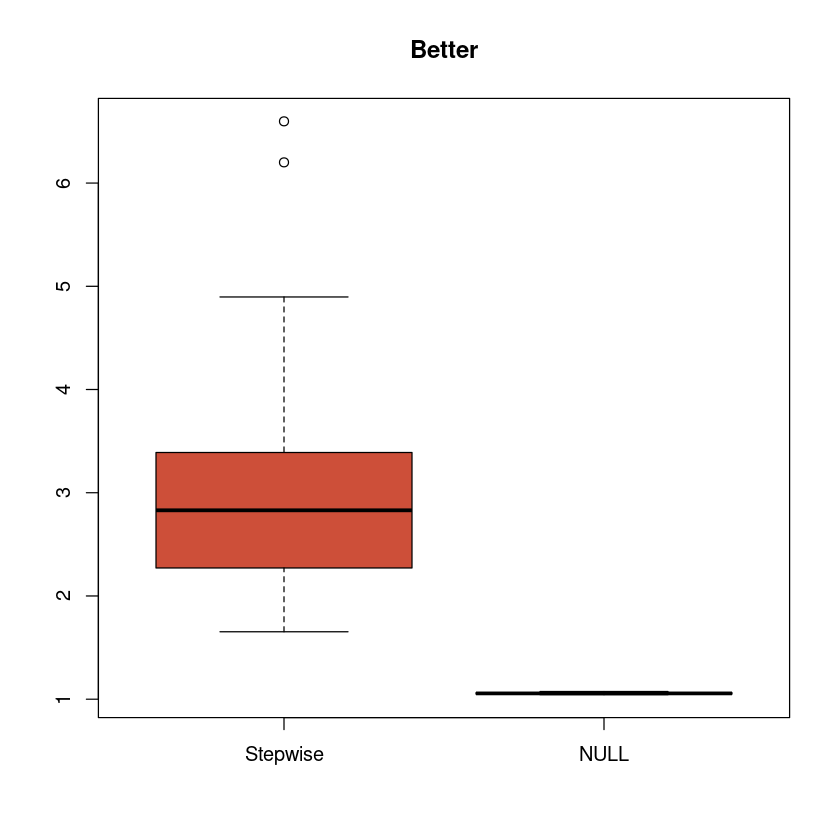

In [8]:
boxplot(mspe.st, mspe.n, names=c('Stepwise', 'NULL'), col=c('tomato3', 'steelblue3'), main='Better')

In [9]:
summary(mspe.st)
summary(mspe.n)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.653   2.278   2.830   2.981   3.372   6.598 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.044   1.050   1.056   1.057   1.063   1.074 